# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

# Results are at the end of the notebook

**I could have wrapped the functions in order to make the code prettier. However, given the computions were quite costly and I wanted to observe results in between I decided to leave them seperately. Each variation of the model took a few hours to run!**

In [1]:
import re
import spacy
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt

In [2]:
yelps = pd.read_csv('../data/sentiment/yelps.csv')

In [3]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile(r'[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

def preprocess(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if t.lemma_ != '-PRON-']
    return ' '.join(words).lower()

vectorizer = TfidfVectorizer(min_df=2,
                             max_df=.8,
                             preprocessor=preprocess,
                             stop_words='english',
                             use_idf=False,
                             norm=False)


#take samples of data
yelps = yelps.sample(frac=1.0)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


In [5]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test= train_test_split(yelps.text,yelps.positive)

In [6]:
# Fit
#v = vectorizer.fit_transform(X_train)
#v = np.asarray(v.todense())
#y = y_train

#labels, _ = zip(*sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1]))


In [11]:
def pre_sample(data,n_samples):
    yelps = data.sample(n=n_samples)
    X=yelps.text
    y=yelps.positive
    return X,y

In [12]:
X,y=pre_sample(yelps,len(yelps))

In [13]:
# create train and test datasets
def create_dataset(n_train, n_test=94000):
    # generate samples
    n_samples = n_train + n_test
    X, y = pre_sample(yelps,n_samples=n_samples)
    #print(X)
    # split into train and test, first n for test
    trainX, testX = X[n_test:], X[:n_test]
    trainy, testy = y[n_test:], y[:n_test]
    
    #    trainX, testX = np.array(X).reshape(-1,1)[n_test:, :], np.array(X).reshape(-1,1)[:n_test, :]
    #trainy, testy = np.array(y).reshape(-1,1)[n_test:], np.array(y).reshape(-1,1)[:n_test]
    
    # return samples
    return trainX, trainy, testX, testy

In [14]:
# evaluate LR model
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    model = LogisticRegression()
    
    #fit vectorizer
    v = vectorizer.fit_transform(trainX)
    v = np.asarray(v.todense())
    y = trainy
    
    # Transform Test Data
    x_test = vectorizer.transform(testX)
    
    # fit model
    model.fit(v, y)
    # evaluate the model
    predy = model.predict(x_test)
    score = accuracy_score(testy, predy)
    return score

In [15]:
trainX, trainy, testX, testy= create_dataset(1000)

In [16]:
evaluate_model(trainX, trainy, testX, testy)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8947765957446808

In [17]:
# repeated evaluation of lr model with dataset of a given size
def evaluate_size(n_train, n_repeats=2):
    # create dataset
    trainX, trainy, testX, testy = create_dataset(n_train)
    # repeat evaluation of model with dataset
    scores = list()
    for _ in range(n_repeats):
        # evaluate model for size
        score = evaluate_model(trainX, trainy, testX, testy)
        scores.append(score)
    return scores

In [19]:
# define dataset sizes to evaluate
sizes = [1000, 2000, 4000]
score_sets1, means1 = list(), list()
for n_train in sizes:
    # repeated evaluate model with training set size
    scores = evaluate_size(n_train)
    score_sets1.append(scores)
    # summarize score for size
    mean_score1 = mean(scores)
    means1.append(mean_score1)
    print('Train Size=%d, Test Accuracy %.3f' % (n_train, mean_score1*100))


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=1000, Test Accuracy 89.807


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=2000, Test Accuracy 91.513


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=4000, Test Accuracy 92.211


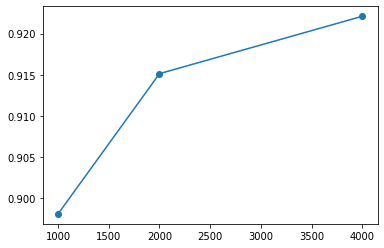

In [20]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means1, marker='o')
plt.show()

## Now doing the same but with the Word2Vec model

In [152]:
#pip install "gensim"

In [22]:
#from nltk import sent_tokenize
from nltk import word_tokenize
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec


In [23]:
# evaluate LR model
def evaluate_model2(X,trainX, trainy, testX, testy):
    # define model
    model = LogisticRegression()
    
    # pre-process data
    trainX_mod = trainX.apply(lambda x: word_tokenize(x.lower()))
    testX_mod = testX.apply(lambda x: word_tokenize(x.lower()))
    docs=X.apply(lambda x: word_tokenize(x.lower()))
    
    #fit Word2Vec
    model2 = Word2Vec(docs, min_count=1,size=50 ,workers=4) #trainX_mod size=50
    model2.train(docs, total_examples=len(docs), epochs=2)
    
    # Train data: WordVec to DocVec
    trainX2_temp=[]
    for doc in trainX_mod:
        doc_vec=np.zeros(shape=(50,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        trainX2_temp+=[doc_vec.tolist()]
    trainX2 = np.asarray(trainX2_temp)
    
    # Test data: WordVec to DocVec
    testX2_temp=[]
    for doc in testX_mod:
        doc_vec=np.zeros(shape=(50,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        testX2_temp+=[doc_vec.tolist()]
    testX2 = np.asarray(testX2_temp)
    
    model.fit(trainX2, trainy)
    # evaluate the model
    predy = model.predict(testX2)
    score = accuracy_score(testy, predy)
    return score

In [24]:
evaluate_model2(X,trainX, trainy, testX, testy)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8995319148936171

In [25]:
# repeated evaluation of lr model with dataset of a given size
def evaluate_size2(n_train, n_repeats=2):
    # create dataset
    trainX, trainy, testX, testy = create_dataset(n_train)
    # repeat evaluation of model with dataset
    scores = list()
    for _ in range(n_repeats):
        # evaluate model for size
        score = evaluate_model2(X,trainX, trainy, testX, testy)
        scores.append(score)
    return scores

In [26]:
# define dataset sizes to evaluate
sizes = [1000, 2000, 4000]
score_sets, means = list(), list()
for n_train in sizes:
    # repeated evaluate model with training set size
    scores = evaluate_size2(n_train)
    score_sets.append(scores)
    # summarize score for size
    mean_score = mean(scores)
    means.append(mean_score)
    print('Train Size=%d, Test Accuracy %.3f' % (n_train, mean_score*100))


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=1000, Test Accuracy 89.937


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=2000, Test Accuracy 91.325


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=4000, Test Accuracy 91.781


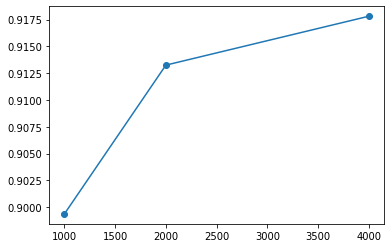

In [27]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means, marker='o')
plt.show()

## Comparing the 2 models

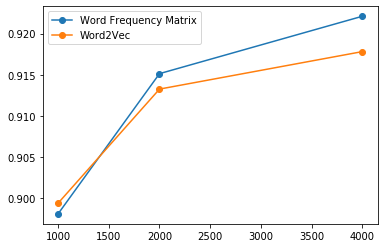

In [28]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means1, marker='o',label='Word Frequency Matrix')
plt.plot(sizes, means, marker='o',label="Word2Vec")
plt.legend()
plt.show()

## Reduced window size = 20

In [29]:
#yelps = pd.read_csv('../data/sentiment/yelps.csv')

In [30]:
#yelps2 = yelps.sample(frac=0.2)

In [ ]:
#X,y=pre_sample(yelps,len(yelps2))

In [13]:
# create train and test datasets
#def create_dataset(n_train, n_test=15000):
    # generate samples
#    n_samples = n_train + n_test
#    X, y = pre_sample(yelps,n_samples=n_samples)
    # split into train and test, first n for test
#    trainX, testX = X[n_test:], X[:n_test]
#    trainy, testy = y[n_test:], y[:n_test]
    
    #    trainX, testX = np.array(X).reshape(-1,1)[n_test:, :], np.array(X).reshape(-1,1)[:n_test, :]
    #trainy, testy = np.array(y).reshape(-1,1)[n_test:], np.array(y).reshape(-1,1)[:n_test]
    
    # return samples
#    return trainX, trainy, testX, testy

In [15]:
#trainX, trainy, testX, testy= create_dataset(1000)

In [52]:
# evaluate LR model
def evaluate_model3(X,trainX, trainy, testX, testy):
    # define model
    model = LogisticRegression()
    
    # pre-process data
    trainX_mod = trainX.apply(lambda x: word_tokenize(x.lower()))
    testX_mod = testX.apply(lambda x: word_tokenize(x.lower()))
    docs=X.apply(lambda x: word_tokenize(x.lower()))
    
    #fit Word2Vec
    model2 = Word2Vec(docs, min_count=1,size=20 ,workers=4) #trainX_mod size=50
    model2.train(docs, total_examples=len(docs), epochs=2)
    
    # Train data: WordVec to DocVec
    trainX2_temp=[]
    for doc in trainX_mod:
        doc_vec=np.zeros(shape=(20,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        trainX2_temp+=[doc_vec.tolist()]
    trainX2 = np.asarray(trainX2_temp)
    
    # Test data: WordVec to DocVec
    testX2_temp=[]
    for doc in testX_mod:
        doc_vec=np.zeros(shape=(20,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        testX2_temp+=[doc_vec.tolist()]
    testX2 = np.asarray(testX2_temp)
    
    model.fit(trainX2, trainy)
    # evaluate the model
    predy = model.predict(testX2)
    score = accuracy_score(testy, predy)
    return score

In [53]:
# repeated evaluation of lr model with dataset of a given size
def evaluate_size3(n_train, n_repeats=2):
    # create dataset
    trainX, trainy, testX, testy = create_dataset(n_train)
    # repeat evaluation of model with dataset
    scores = list()
    for _ in range(n_repeats):
        # evaluate model for size
        score = evaluate_model3(X,trainX, trainy, testX, testy)
        scores.append(score)
    return scores

In [54]:
# define dataset sizes to evaluate
sizes = [1000, 2000, 4000]
score_sets3, means3 = list(), list()
for n_train in sizes:
    # repeated evaluate model with training set size
    scores = evaluate_size3(n_train)
    score_sets3.append(scores)
    # summarize score for size
    mean_score3 = mean(scores)
    means3.append(mean_score3)
    print('Train Size=%d, Test Accuracy %.3f' % (n_train, mean_score3*100))


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=1000, Test Accuracy 87.612


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=2000, Test Accuracy 88.535


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=4000, Test Accuracy 88.404


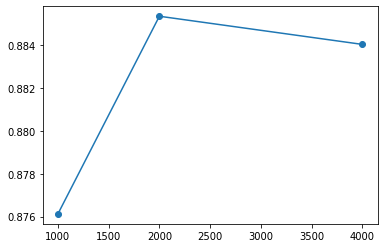

In [55]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means3, marker='o')
plt.show()

## Window size 500

In [68]:
# evaluate LR model
def evaluate_model5(X,trainX, trainy, testX, testy):
    # define model
    model = LogisticRegression()
    
    # pre-process data
    trainX_mod = trainX.apply(lambda x: word_tokenize(x.lower()))
    testX_mod = testX.apply(lambda x: word_tokenize(x.lower()))
    docs=X.apply(lambda x: word_tokenize(x.lower()))
    
    #fit Word2Vec
    model2 = Word2Vec(docs, min_count=1,size=500 ,workers=4) #trainX_mod size=50
    model2.train(docs, total_examples=len(docs), epochs=2)
    
    # Train data: WordVec to DocVec
    trainX2_temp=[]
    for doc in trainX_mod:
        doc_vec=np.zeros(shape=(500,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        trainX2_temp+=[doc_vec.tolist()]
    trainX2 = np.asarray(trainX2_temp)
    
    # Test data: WordVec to DocVec
    testX2_temp=[]
    for doc in testX_mod:
        doc_vec=np.zeros(shape=(500,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        testX2_temp+=[doc_vec.tolist()]
    testX2 = np.asarray(testX2_temp)
    
    model.fit(trainX2, trainy)
    # evaluate the model
    predy = model.predict(testX2)
    score = accuracy_score(testy, predy)
    return score

In [69]:
# repeated evaluation of lr model with dataset of a given size
def evaluate_size5(n_train, n_repeats=1):
    # create dataset
    trainX, trainy, testX, testy = create_dataset(n_train)
    # repeat evaluation of model with dataset
    scores = list()
    for _ in range(n_repeats):
        # evaluate model for size
        score = evaluate_model5(X,trainX, trainy, testX, testy)
        scores.append(score)
    return scores

In [70]:
# define dataset sizes to evaluate
sizes = [1000, 2000, 4000]
score_sets5, means5 = list(), list()
for n_train in sizes:
    # repeated evaluate model with training set size
    scores = evaluate_size5(n_train)
    score_sets5.append(scores)
    # summarize score for size
    mean_score5 = mean(scores)
    means5.append(mean_score5)
    print('Train Size=%d, Test Accuracy %.3f' % (n_train, mean_score5*100))


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=1000, Test Accuracy 91.040


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=2000, Test Accuracy 92.470


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=4000, Test Accuracy 93.313


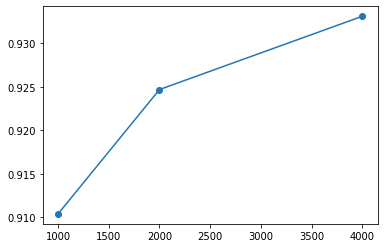

In [71]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means5, marker='o')
plt.show()

## Window size 2500

In [101]:
# evaluate LR model
def evaluate_model6(X,trainX, trainy, testX, testy):
    # define model
    model = LogisticRegression()
    
    # pre-process data
    trainX_mod = trainX.apply(lambda x: word_tokenize(x.lower()))
    testX_mod = testX.apply(lambda x: word_tokenize(x.lower()))
    docs=X.apply(lambda x: word_tokenize(x.lower()))
    
    #fit Word2Vec
    model2 = Word2Vec(docs, min_count=1,size=2500 ,workers=4) #trainX_mod size=50
    model2.train(docs, total_examples=len(docs), epochs=2)
    
    # Train data: WordVec to DocVec
    trainX2_temp=[]
    for doc in trainX_mod:
        doc_vec=np.zeros(shape=(2500,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        trainX2_temp+=[doc_vec.tolist()]
    trainX2 = np.asarray(trainX2_temp)
    
    # Test data: WordVec to DocVec
    testX2_temp=[]
    for doc in testX_mod:
        doc_vec=np.zeros(shape=(2500,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        testX2_temp+=[doc_vec.tolist()]
    testX2 = np.asarray(testX2_temp)
    
    model.fit(trainX2, trainy)
    # evaluate the model
    predy = model.predict(testX2)
    score = accuracy_score(testy, predy)
    return score

In [102]:
# repeated evaluation of lr model with dataset of a given size
def evaluate_size6(n_train, n_repeats=1):
    # create dataset
    trainX, trainy, testX, testy = create_dataset(n_train)
    # repeat evaluation of model with dataset
    scores = list()
    for _ in range(n_repeats):
        # evaluate model for size
        score = evaluate_model6(X,trainX, trainy, testX, testy)
        scores.append(score)
    return scores

In [103]:
# define dataset sizes to evaluate
sizes = [1000, 2000, 4000]
score_sets6, means6 = list(), list()
for n_train in sizes:
    # repeated evaluate model with training set size
    scores = evaluate_size6(n_train)
    score_sets6.append(scores)
    # summarize score for size
    mean_score6 = mean(scores)
    means6.append(mean_score6)
    print('Train Size=%d, Test Accuracy %.3f' % (n_train, mean_score6*100))


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=1000, Test Accuracy 91.283


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=2000, Test Accuracy 92.253


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=4000, Test Accuracy 93.060


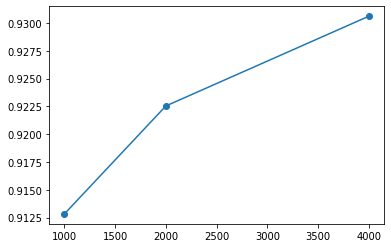

In [104]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means6, marker='o')
plt.show()

In [ ]:
#del yelps2

# Next Test skip-gram vs BOW, training windows

### Skip Gram

In [105]:
# evaluate LR model
def evaluate_model7(X,trainX, trainy, testX, testy):
    # define model
    model = LogisticRegression()
    
    # pre-process data
    trainX_mod = trainX.apply(lambda x: word_tokenize(x.lower()))
    testX_mod = testX.apply(lambda x: word_tokenize(x.lower()))
    docs=X.apply(lambda x: word_tokenize(x.lower()))
    
    #fit Word2Vec
    model2 = Word2Vec(docs, min_count=1,size=50 ,sg=1,workers=4) #trainX_mod size=50 sg=1 is skip-gram,
    model2.train(docs, total_examples=len(docs), epochs=2)
    
    # Train data: WordVec to DocVec
    trainX2_temp=[]
    for doc in trainX_mod:
        doc_vec=np.zeros(shape=(50,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        trainX2_temp+=[doc_vec.tolist()]
    trainX2 = np.asarray(trainX2_temp)
    
    # Test data: WordVec to DocVec
    testX2_temp=[]
    for doc in testX_mod:
        doc_vec=np.zeros(shape=(50,)) # 50 because size=50 (per def. in Word2Vec)
        for word in doc:
            doc_vec+= model2.wv.__getitem__(word)
        doc_vec=doc_vec/np.linalg.norm(doc_vec) # taking L2 norm
        testX2_temp+=[doc_vec.tolist()]
    testX2 = np.asarray(testX2_temp)
    
    model.fit(trainX2, trainy)
    # evaluate the model
    predy = model.predict(testX2)
    score = accuracy_score(testy, predy)
    return score

In [106]:
# repeated evaluation of lr model with dataset of a given size
def evaluate_size7(n_train, n_repeats=1):
    # create dataset
    trainX, trainy, testX, testy = create_dataset(n_train)
    # repeat evaluation of model with dataset
    scores = list()
    for _ in range(n_repeats):
        # evaluate model for size
        score = evaluate_model7(X,trainX, trainy, testX, testy)
        scores.append(score)
    return scores

In [107]:
# define dataset sizes to evaluate
sizes = [1000, 2000, 4000]
score_sets7, means7 = list(), list()
for n_train in sizes:
    # repeated evaluate model with training set size
    scores = evaluate_size7(n_train)
    score_sets7.append(scores)
    # summarize score for size
    mean_score7 = mean(scores)
    means7.append(mean_score7)
    print('Train Size=%d, Test Accuracy %.3f' % (n_train, mean_score7*100))


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=1000, Test Accuracy 87.214


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=2000, Test Accuracy 89.316


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Size=4000, Test Accuracy 91.284


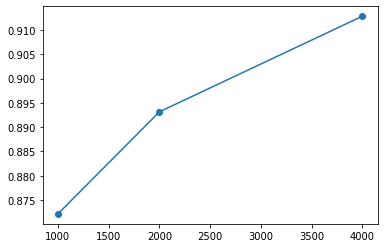

In [108]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means7, marker='o')
plt.show()

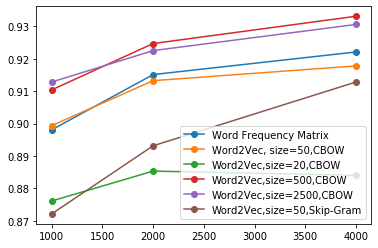

In [110]:
# summarize relationship of train size to test accuracy
plt.plot(sizes, means1, marker='o',label='Word Frequency Matrix')
plt.plot(sizes, means, marker='o',label="Word2Vec, size=50,CBOW")
plt.plot(sizes, means3, marker='o',label="Word2Vec,size=20,CBOW")
plt.plot(sizes, means5, marker='o',label="Word2Vec,size=500,CBOW")
plt.plot(sizes, means6, marker='o',label="Word2Vec,size=2500,CBOW")
plt.plot(sizes, means7, marker='o',label="Word2Vec,size=50,Skip-Gram")
plt.legend()
plt.show()

**Word Frequency vs. Word2Vec:**

As we can see the overall performance of the Word Frequency Matrix is comparable to Word2Vec. Both models' out of sample test accuracy improve, when increasing the training data size.

**Window Size:**

When the window size is decreased we can see no increase in accuracy when we increase the training size. Also further below when the window size is set too large the accuracy suffers. Arora (2016) expressed this phenomenon as follows:“...  A striking finding in empirical work on word embeddings is that **there is a sweet spot for the dimensionality of word vectors: neither too small, nor too large**”. This phenomenon is closely related to the well known bias-viariance trade-off.

**Skip-Gram vs CBOW**:

Interestingly, the skip-gram method in Word2Vec has a major impact on the performance of the classification model, particularly for larger training data. The Skip-Gram method (brown line) first performs worse than the model with equivalent window size (orange line). According to various sources I have found online Skip-Gram works well with small amount of data and performs well for rare words. At least the former seems to contradict my results here. However if we look at the magnitude of the differences in accuracy here one might also argue that more epochs should have been run for more robust comparison.